## Project Definition

This notebook is created to develop an analytics solution for a Kohl's take home assignment for a Data Scientist position.

The goal of the project is to predict the amount of purchase based on the provided data.

In [1]:
# importing required packages
import pandas as pd  # for data manipulation and analysis
import matplotlib.pyplot as plt  # for visualization
from scipy.stats import ttest_ind  # to perform t-test
import statsmodels.api as sm  # to perform ANOVA test
from statsmodels.formula.api import ols  # to perform ANOVA test
import seaborn as sns # to perform visualization
import numpy as np # for some correlation studff
# for modelling
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV  # for hyperparameter tuning

C:\ProgramData\Anaconda5\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# first let's take a look at the data set
data = pd.read_csv('data/train.csv')
data.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


In [3]:
# now let's take a look at the statistics of each columns
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 12 columns):
User_ID                       550068 non-null int64
Product_ID                    550068 non-null object
Gender                        550068 non-null object
Age                           550068 non-null object
Occupation                    550068 non-null int64
City_Category                 550068 non-null object
Stay_In_Current_City_Years    550068 non-null object
Marital_Status                550068 non-null int64
Product_Category_1            550068 non-null int64
Product_Category_2            376430 non-null float64
Product_Category_3            166821 non-null float64
Purchase                      550068 non-null int64
dtypes: float64(2), int64(5), object(5)
memory usage: 50.4+ MB


Few points to notice:
- Except columns ``product category2`` and ``product category 3``, all of other columns have no null values.

Let's quickly take a look at the numerical data summary.

In [4]:
data.describe()

,User_ID,Occupation,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
count,5.500680e+05,550068.000000,550068.000000,550068.000000,376430.000000,166821.000000,550068.000000
mean,1.003029e+06,8.076707,0.409653,5.404270,9.842329,12.668243,9263.968713
std,1.727592e+03,6.522660,0.491770,3.936211,5.086590,4.125338,5023.065394
min,1.000001e+06,0.000000,0.000000,1.000000,2.000000,3.000000,12.000000
25%,1.001516e+06,2.000000,0.000000,1.000000,5.000000,9.000000,5823.000000
50%,1.003077e+06,7.000000,0.000000,5.000000,9.000000,14.000000,8047.000000
75%,1.004478e+06,14.000000,1.000000,8.000000,15.000000,16.000000,12054.000000
max,1.006040e+06,20.000000,1.000000,20.000000,18.000000,18.000000,23961.000000


Observations:
- There are 21 occupation categories that are encoded with integer numbers
- There are two martial status (married, single) that are encoded by 0,1.
- There are 20 product category 1 that are encoded by integer 1-20.
- There are 17 product category 2 that are encoded by integers 2-18
- There are 16 product category 3 that are encoded by integers 3-18
- Purchase is numerical (integer)

How about categorical data summary?

In [5]:
data.describe(include = ['O'])  # includes object data types as well

,Product_ID,Gender,Age,City_Category,Stay_In_Current_City_Years
count,550068,550068,550068,550068,550068
unique,3631,2,7,3,5
top,P00265242,M,26-35,B,1
freq,1880,414259,219587,231173,193821


Observations:
- Product id has 3631 elements. These are many categories that we need to think about how to encode.
- Gender: male and female, needs to be labeled.
- There are three cities in this data set.
- Stay in current city has 5 unique value, and 1 is more frequent. Need to check why this is not integer. Looking at the followin cell, there are 5 categories: 0, 1, 2, 3, 4+ and that is why this column is not integer. Needs to be cleaned.

In [6]:
data.Stay_In_Current_City_Years.unique()

array(['2', '4+', '3', '1', '0'], dtype=object)

> except the target variable, all the features are categorical. Decision trees seem to be a go to way for solving this problem.

### Dealing with null values:
We noticed that only two features have null values. We need to check if these null values carry any information so that we decide how to deal with them.

We do the following:
- Eyeballing and checking whether the missing column has any information.
- If that is the case performing a hypothesis test to make sure (will be anova)
- Finally, encode the missing value if we found any information.

In [7]:
data.fillna('missing', inplace = True) # first let's have missing values accesible

In [8]:
categ2_by_purchase = data.groupby('Product_Category_2').Purchase.mean().sort_values()
print(categ2_by_purchase)

Product_Category_2
7.0         6884.683706
12.0        6975.472504
14.0        7105.264916
9.0         7277.006851
missing     7518.695389
11.0        8940.580515
5.0         9027.821574
18.0        9352.440433
17.0        9421.576577
13.0        9683.352388
4.0        10215.192001
8.0        10273.259518
16.0       10295.681933
15.0       10357.077691
3.0        11235.359570
6.0        11503.551379
2.0        13619.356401
10.0       15648.729543
Name: Purchase, dtype: float64


We notice a meaningful difference between missing category and other categories.

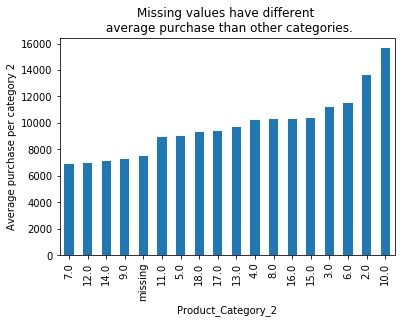

In [9]:
categ2_by_purchase.plot(kind = 'bar')
_ = plt.ylabel('Average purchase per category 2')
_ = plt.title('Missing values have different \n \
average purchase than other categories.')

Now we quickly run a t-test to make sure what we see is also statistically significant. 
- Null hypothesis: missing values dont have different response that other values
- Alternative hypothesis: missing values have different response than others

Now let's slice the data set so that we can run on the category 2 data.

In [10]:
def missing_parser(series):
    '''Lump all non missing elements into one value'''
    if series == 'missing':
        return series
    else:
        return "non-missing"
    
    
cat2_data = data[['Product_Category_2', 'Purchase']]
cat2_data['Product_Category_2'] = cat2_data['Product_Category_2'].apply(missing_parser)

C:\ProgramData\Anaconda5\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [11]:
cat2_data.groupby('Product_Category_2').mean()

,Purchase
Product_Category_2,
missing,7518.695389
non-missing,10069.020833


Again, we can see that the missing data has significantly different purchase rate. How about t-test.

In [12]:
missing = cat2_data[cat2_data.Product_Category_2 == 'missing'].Purchase # getting purchase values for missing
non_missing = cat2_data[cat2_data.Product_Category_2 == 'non-missing'].Purchase # getting purchase values for non - missing

In [13]:
ttest_ind(non_missing, missing, equal_var=False)  # I checked standard deviation and they had different variance

Ttest_indResult(statistic=195.43439773414013, pvalue=0.0)

> p-value is infismal and so we statistcally proved that the nan values in the category2 column needs to be included in our study.

Now let's quickly go over the second column (product category 3) that has null values and perform the same:
- Eyeballing and checking whether the missing column has any information.
- If that is the case performing a hypothesis test to make sure (will be anova)
- Finally, encode the missing value if we found any information.

In [14]:
categ3_by_purchase = data.groupby('Product_Category_3').Purchase.mean().sort_values()
print(categ3_by_purchase)

Product_Category_3
missing     8221.836943
12.0        8715.512762
4.0         9794.386667
14.0       10052.594530
9.0        10431.697210
18.0       10993.980773
17.0       11769.943001
16.0       11981.890642
11.0       12091.437673
5.0        12117.786889
15.0       12339.369900
8.0        13024.918882
13.0       13185.118703
6.0        13194.311043
10.0       13505.813441
3.0        13939.696574
Name: Purchase, dtype: float64


Again we can observe meaningful difference. But difference is less obvious. Let's visually check it.

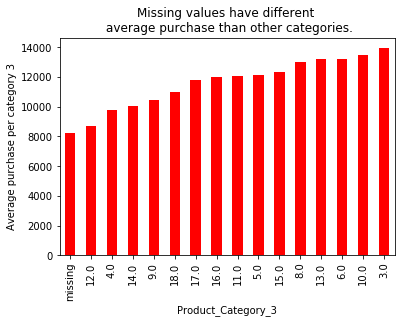

In [15]:
categ3_by_purchase.plot(kind = 'bar', color = 'red')
_ = plt.ylabel('Average purchase per category 3')
_ = plt.title('Missing values have different \n \
average purchase than other categories.')

In [16]:
cat3_data = data[['Product_Category_3', 'Purchase']]
cat3_data['Product_Category_3'] = cat3_data['Product_Category_3'].apply(missing_parser)
cat3_data.groupby('Product_Category_3').mean()

C:\ProgramData\Anaconda5\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Purchase
Product_Category_3,
missing,8221.836943
non-missing,11658.114980


In [17]:
missing = cat3_data[cat3_data.Product_Category_3 == 'missing'].Purchase # getting purchase values for missing
non_missing = cat3_data[cat3_data.Product_Category_3 == 'non-missing'].Purchase # getting purchase values for non - missing
ttest_ind(non_missing, missing, equal_var=False)  # I checked standard deviation and they had different variance

Ttest_indResult(statistic=236.76167142324044, pvalue=0.0)

Again, p-value is statistically significant and so we need to generate a new level for missing data.

## Feature Engineering

Let's check fatures one by one and see if we can genearte insight from them.

- Occupation

Text(0.5,1,'Occupation vs purchase')

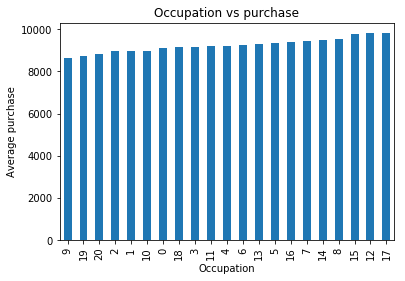

In [18]:
occu_pruchase = data.groupby('Occupation').Purchase.mean().sort_values()
occu_pruchase.plot(kind='bar')
plt.ylabel("Average purchase")
plt.title('Occupation vs purchase')

Diffeent occupation seems to have pretty close purchase avearge. Is this data still informative or do we have to throw it out?
We use ANOVA test:
- Null hypothesis : there is no difference between mean purchases of different occupations
- Alternative Hypothesis: at least one of the average purhcases for occuations is different than others

In [19]:
mod = ols('Purchase ~ Occupation',
                data=data).fit()
                
aov_table = sm.stats.anova_lm(mod, typ=2)
print (aov_table)

                  sum_sq        df           F        PR(>F)
Occupation  6.023389e+09       1.0  238.831156  7.259684e-54
Residual    1.387282e+13  550066.0         NaN           NaN


Although the visualized represnetation did not completely show, the categorical variables in the occupation columns have intrisic information about the target. Therefore, we keep it. Moreover, since the levels are already numerical, we dont have to work on engineering new feature. We keep the column as is.

Next ``Gender``:


In [20]:
data.groupby('Gender').Purchase.mean().sort_values()

Gender
F    8734.565765
M    9437.526040
Name: Purchase, dtype: float64

There is some meaningful difference between male and female purchases.

Text(0.5,1,'Gender vs purchase history')

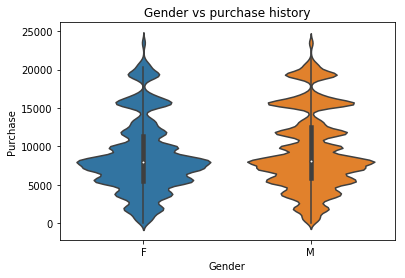

In [21]:
_ = sns.violinplot(x="Gender", y="Purchase", data=data)
plt.title("Gender vs purchase history")

In [22]:
# Again, there seems some difference, visualy, let's prove statistically
male = data[data.Gender == 'M'].Purchase # male purchases
female = data[data.Gender == 'F'].Purchase # female purchases
ttest_ind(male, female)

Ttest_indResult(statistic=44.837957934353966, pvalue=0.0)

We see that gender is statistically speaking informative in predicting purchases. We keep this feature. We only need to label encode the classes: male: 0, female:1.

> Let's work on the Age column.

In [23]:
data.groupby('Age').Purchase.mean().sort_values()

Age
0-17     8933.464640
18-25    9169.663606
46-50    9208.625697
26-35    9252.690633
36-45    9331.350695
55+      9336.280459
51-55    9534.808031
Name: Purchase, dtype: float64

Very small difference between different age groups. Let's visually see.

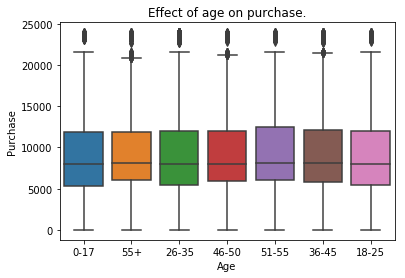

In [24]:
_ = sns.boxplot(x="Age", y="Purchase" ,data=data)
_ = plt.title('Effect of age on purchase.')

Again, visually there donest seem to be any valuable information. Let's check statistics:

In [25]:
mod = ols('Purchase ~ Age',
                data=data).fit()
                
aov_table = sm.stats.anova_lm(mod, typ=2)
print (aov_table)

                sum_sq        df          F        PR(>F)
Age       6.140003e+09       6.0  40.575799  1.053564e-49
Residual  1.387270e+13  550061.0        NaN           NaN


This is a huge data set and even a slight difference seems to bring statistcally significant results. Personally, I think we can drop age. However, since the goal is to minimize test set MSE, I will keep it. We need to later work on the model to decrease the variance due to this feature.

We just need to again label encode this feature to be used in the final model.
Please refer to ``age_eng`` function for more details.
> Now let's take a look at city_category:

In [26]:
data.groupby('City_Category').Purchase.mean().sort_values()

City_Category
A    8911.939216
B    9151.300563
C    9719.920993
Name: Purchase, dtype: float64

There seems to be some difference. Let's take a closer look.

Text(0.5,1,'City Category vs purchase history')

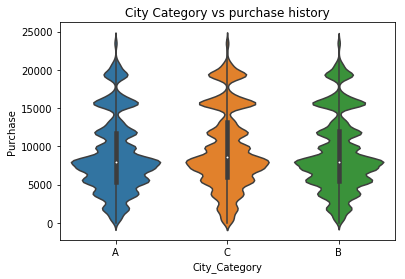

In [27]:
_ = sns.violinplot(x="City_Category", y="Purchase", data=data)
plt.title("City Category vs purchase history")

Again, visually I can see some difference in the violin plot. Let's perform ANOVA test to make sure the results are statistically significant.

In [28]:
mod = ols('Purchase ~ City_Category',
                data=data).fit()
                
aov_table = sm.stats.anova_lm(mod, typ=2)
print (aov_table)

                     sum_sq        df            F  PR(>F)
City_Category  5.682670e+10       2.0  1130.745961     0.0
Residual       1.382202e+13  550065.0          NaN     NaN


Same goes with city category, we keep it. We only have to make it numerical.

Next very important column is product id. It is quite a peculiar one as it has thousands of levels. Let's take a look at it. I suggest mean-encoding it then rank encoding it.

There are 3631 number of elements in product category


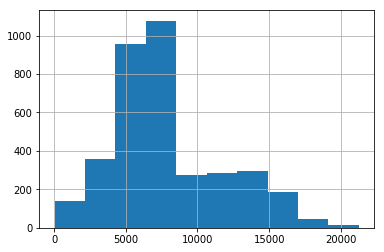

In [53]:
product = data.groupby('Product_ID')['Purchase'].mean().sort_values()
print("There are {} number of elements in product category".format(len(product)))
product_avg = np.mean(product) # to be used in cases that the product id is not available
product.hist()

Now I would like to first use mean-target encoding to replace each ID with the corrsponding mean of target for that ID.

In [30]:
product.head()

Product_ID
P00370293     36.675159
P00370853     37.393643
P00371644    362.911012
P00375436    374.266585
P00372445    374.930705
Name: Purchase, dtype: float64

We can see that the difference between neighbor products in terms of mean purchase value is very close to each other. Therefore, I suggest using rank-labeling. Basically, we label products from 0 to number of products. Therefore, making categories that are in essence related to purchase.

In [31]:
product_replacer = pd.Series(range(len(product)))
product_replacer.index = product.index.values
product_replacer.head()

P00370293    0
P00370853    1
P00371644    2
P00375436    3
P00372445    4
dtype: int64

In [32]:
product_dict = dict(product_replacer)
encoded_product = data.Product_ID.apply(lambda x: product_dict[x])

Text(0,0.5,'purchases')

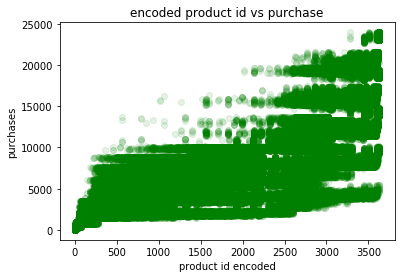

In [33]:
plt.scatter(encoded_product, data.Purchase, alpha = 0.1, color = 'green')
plt.title("encoded product id vs purchase")
plt.xlabel('product id encoded')
plt.ylabel('purchases')

We see some meaningful correlation. Let's check the correleation.

In [34]:
correlation = np.corrcoef(encoded_product, data.Purchase)
print("Correlation between encoded roduct ID and purchase is {}".format(correlation))

Correlation between encoded roduct ID and purchase is [[1.         0.80415585]
 [0.80415585 1.        ]]


Let's take a look at scatter plot of this column and the purchase column.

There is a high correlation between the two variables. Therefore, we will keep this encoded variable as well.

> Due to time limit, I will assume that the rest of the columns are also important. Therefore, I will keep them. Since we are using random forsest, I will use large number of estimator to rule out these noises.

In [55]:
def gender_encoder(column):
    '''encode gender categories into zero and one'''
    gender_encoder = {'M': 0, 'F': 1}
    return gender_encoder[column]

age_dict = {v:k for k, v in dict(enumerate(data.Age.unique())).items()}  # quick and dirty way of encoding
def age_encoder(column):
    return age_dict[column]

city_dict = {v:k for k, v in dict(enumerate(data.City_Category.unique())).items()}  # quick and dirty way of encoding
def city_encoder(column): 
    return city_dict[column] 

stay_dict = {v:k for k, v in dict(enumerate(data.Stay_In_Current_City_Years.unique())).items()}  # quick and dirty way of encoding
def stay_encoder(column): 
    return stay_dict[column] 

# product_dict defined few cells above
def product_encoder(column):
    try:
        return product_dict[column]
    except:
        return product_avg  # in case the produc ID is not available 

def feature_engineering(dataset):
    '''preprocessing fucntion to be used to clean both the training and test data sets'''
    dataset['Product_Category_2'] = dataset['Product_Category_2'].fillna(1) # replace the missing values with category 1 (new category)
    dataset['Product_Category_3'] = dataset['Product_Category_3'].fillna(1) # replace the missing values with category 1 (new category)
    dataset['Gender'] = dataset['Gender'].apply(gender_encoder)  # encoding gender column
    dataset['Age'] = dataset['Age'].apply(age_encoder)  # encoding age column
    dataset['City_Category'] = dataset['City_Category'].apply(city_encoder)  # encoding city column
    dataset['Stay_In_Current_City_Years'] = dataset['Stay_In_Current_City_Years'].apply(stay_encoder)  # encoding city column
    dataset['Product_ID'] = dataset['Product_ID'].apply(product_encoder)  # encoding city column
    # deleting unwanted columns
    dataset = dataset.drop('User_ID', axis = 1)  # both test and train set have User_ID
    try:
        dataset = dataset.drop('Purchase' , axis = 1)
    except:
        pass
    
    return dataset

### Making data ready for the model
We drop the ID column and the target column and seperate the target column as label.

In [36]:
train = pd.read_csv('data/train.csv')  # re-inputing training data set to peform feature engineering
y = train.Purchase

In [37]:
X = feature_engineering(train)

In [38]:
X.head()

,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3
0,2956,1,0,10,0,0,0,3,1.0,1.0
1,3518,1,0,10,0,0,0,1,6.0,14.0
2,49,1,0,10,0,0,0,12,1.0,1.0
3,68,1,0,10,0,0,0,12,14.0,1.0
4,2258,0,1,16,1,1,0,8,1.0,1.0


In [39]:
X_train, X_hold, y_train, y_hold = train_test_split(X, y, test_size = 0.33, random_state = 0)

## Building the model
I am suggesting to use randomforest classifier. First due to the fact that we have so many categorical variables and tree based algorithms are good with categorical variables. Second, they can handle non linerity in data. And finally, since we are using many variables that have minor information, we might face high variance and random forest intrisitc randomization and ensembling can handle this.

In [40]:
rf = RandomForestRegressor(random_state = 0, n_jobs=-1)
# we will use gridsearchcv to find the best parameters for this analysis

# the following lines will be commented as we dont have enugh time to perform depe hyperparaeter tuning
#param_grid = {
#    'bootstrap': [True],
#    'max_depth': [3, 10, 30, 100],
#    'max_features': [3, 8, 'auto'],
#    'min_samples_leaf': [3, 6, 9],
#    'min_samples_split': [8, 10, 12],
#    'n_estimators': [5, 25, 50, 100]
#}

# simple hyperparameter tuning
param_grid = {
    'max_depth': [3, 10],
     'max_features': [8, 'auto'],
    'n_estimators': [10, 50]
}
reg = GridSearchCV(rf, param_grid=param_grid, cv=5, n_jobs=-1)
reg.fit(X_train, y_train) # training the mode

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=0, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [3, 10], 'max_features': [8, 'auto'], 'n_estimators': [10, 50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [41]:
# best hyper parameters:
reg.best_params_

{'max_depth': 10, 'max_features': 8, 'n_estimators': 50}

In [42]:
best_reg = reg.best_estimator_

In [43]:
print("train set R^2")
R_2_train =  round(best_reg.score(X_train, y_train),4)# R squared for this regressor
print("This model resulted in R-squared of {} for training set".format(R_2_train))

train set R^2
This model resulted in R-squared of 0.731 for training set


In [44]:
predictions = best_reg.predict(X_hold)

In [45]:
R_2 =  round(best_reg.score(X_hold, y_hold),4)# R squared for this regressor
print("This model resulted in R-squared of {} for holdout set".format(R_2))
print("{}% of the variance in data is explained".format(R_2 * 100))

This model resulted in R-squared of 0.7274 for holdout set
72.74000000000001% of the variance in data is explained


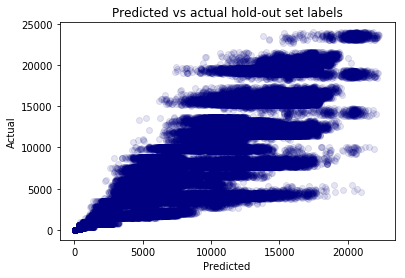

In [50]:
plt.scatter(predictions, y_hold, color='Navy', alpha=0.1) 
plt.title("Predicted vs actual hold-out set labels")
_ = plt.xlabel('Predicted')
_ = plt.ylabel('Actual')

# Conclusion:

We have peformed a non-linear regression in hope to predict the purchase value base on customer beahviour, and product characteristics. We performed feaure engineering, feature analysis, EDA, visualized EDA, hypothesis testing, and finally we built a randomforest regressor to predict the purchase variable. Our model showed it can explain % of the variance of the target variable. 
Now let's perform the prediction on the test data provided.

In [64]:
test = pd.read_csv('data/test.csv')  # re-inputing training data set to peform feature engineering
user_id = test.User_ID
X_test = feature_engineering(test)
prediction_test = best_reg.predict(X_test)

In [65]:
prediction_test_df = pd.DataFrame({'User_ID':user_id,'prediction':prediction_test})
prediction_test_df.to_csv('output.csv')